In [1]:
################################### for avoiding the bug
from sys import platform as sys_pf
if sys_pf == 'darwin':
    import matplotlib
    matplotlib.use("TkAgg")
###################################

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
################################### Import statements
import scipy.io
import pandas as pd
import numpy as np
from sklearn.naive_bayes import GaussianNB
import matplotlib.pyplot as plt
from scipy.stats import norm
import plotly.offline as py
import plotly.graph_objs as go
import plotly.tools as tls
%matplotlib inline  
###################################

In [4]:
################################### Load the data
mat = scipy.io.loadmat('data.mat')
F1 = pd.DataFrame.from_dict(mat.get('F1'))
F2 = pd.DataFrame.from_dict(mat.get('F2'))
###################################

In [5]:
################################### Navie Bayes instance
gnb = GaussianNB()
###################################

In [6]:
################################### plotly helpers
def plotUsingPlotly(x, y, x1, y1):
    trace0 = go.Scatter(
        x=x,
        y=y,
        name = 'Above',
        mode = 'markers',
        marker = dict(
            size = 10,
            color = 'rgba(152, 0, 0, .8)',
            line = dict(
                width = 2,
                color = 'rgb(0, 0, 0)'
            )
        )
    )

    trace1 = go.Scatter(
        x = x1,
        y = y1,
        name = 'Below',
        mode = 'markers',
        marker = dict(
            size = 10,
            color = 'rgba(255, 182, 193, .9)',
            line = dict(
                width = 2,
            )
        )
    )

    data = [trace0, trace1]

    layout = dict(title = 'Styled Scatter',
                  yaxis = dict(zeroline = False),
                  xaxis = dict(zeroline = False)
                 )

    fig = dict(data=data, layout=layout)
    py.iplot(fig, filename='styled-scatter')
###################################

In [7]:
################################### helper function to calculate the accuracy
def getAccuracy(y_pred, yTestOp):
    correct = 0
    for x in range(len(y_pred)):
        if y_pred[x] == yTestOp[x]:
            correct += 1
            incorrect = len(y_pred) - correct
    return (correct/float(len(y_pred))), incorrect/len(y_pred)
###################################


In [8]:
################################### helper function to calculate the log posterior probability
def getAccuracy(y_pred, yTestOp):
    correct = 0
    for x in range(len(y_pred)):
        if y_pred[x] == yTestOp[x]:
            correct += 1
            incorrect = len(y_pred) - correct
    return (correct/float(len(y_pred))), incorrect/len(y_pred)
###################################

In [9]:
################################### step 2.1: calculate the mean and variance for both F1 and F2:
meanListF1 = []
varListF1 = []

meanListF2 = []
varListF2 = []

#for naive bayes
dataF1 = pd.Series()
dataF2 = pd.Series()
dataTestF1 = pd.Series()
dataTestF2 = pd.Series()

for i in range(5):
    #train data
    TaskF1, TaskF2 = F1.ix[ : 99,i], F2.ix[ : 99,i]
    #test data
    TaskTestF1, TaskTestF2 = F1.ix[100 : , i], F2.ix[100 : , i]

    meanF1, varianceF1 = TaskF1.mean(), TaskF1.var()
    meanF2, varianceF2 = TaskF2.mean(), TaskF2.var()

    meanListF1.append(meanF1)
    varListF1.append(varianceF1)
    meanListF2.append(meanF2)
    varListF2.append(varianceF2)

    #for naive bayes
    dataF1 = dataF1.append(TaskF1)
    dataF2 = dataF2.append(TaskF2)

    dataTestF1 = dataTestF1.append(TaskTestF1)
    dataTestF2 = dataTestF2.append(TaskTestF2)


dftrain = pd.DataFrame(data=dict(F1=dataF1, F2=dataF2))
dftest = pd.DataFrame(data=dict(F1=dataTestF1, F2=dataTestF2))


XF1 = dataF1
X = dftrain.values
Y = np.empty([0])

#True op
for i in range(5):
    temp = np.repeat(i, 100)
    Y = np.append(Y, temp)

#fitting naive bayes model
model = gnb.fit(XF1.values.reshape(-1, 1), Y)
modelF2 = gnb.fit(dataF2.values.reshape(-1, 1), Y)

#fitting multivariate naive bayes model
modelF1F2 = gnb.fit(X, Y)

# Do the prediction
y_pred = model.predict(dataTestF1.values.reshape(-1, 1))
y_predF2 = modelF2.predict(dataTestF2.values.reshape(-1, 1))
y_predF1F2 = modelF1F2.predict(dftest)

#lets calculate the prediction error
#first lets get the Y straight
yTestOp = np.empty([0])
for i in range(5):
    temp = np.repeat(i, 900)
    yTestOp = np.append(yTestOp, temp)


classification_accuracy, error_rate = getAccuracy(y_pred, yTestOp)
classification_accuracy_F1F2, error_rate_F1F2 = getAccuracy(y_predF1F2, yTestOp)

print("Case 1: X = F1 \nclassification_accuracy_F1 " + "error_rate_F1", classification_accuracy, error_rate)
#print("classification_accuracy_F1F2_NB " + "error_rate_F1F2_NB", classification_accuracy_F1F2, error_rate_F1F2)
###################################

Case 1: X = F1 
classification_accuracy_F1 error_rate_F1 0.30266666666666664 0.6973333333333334


In [10]:
################################### lets get the prediction accuracy and error rate using log likelyhood approach F1
maxProbListF1 = []
maxProbListF2 = []

for i in range(5):
    TaskTestF1, TaskTestF2 = F1.ix[100:, i], F2.ix[100:, i]
    for j in range(len(TaskTestF1)):
        values = []
        valuesF2 = []
        for k in range(5):

            probClass = norm.pdf(meanListF1[k], varListF1[k], TaskTestF1.iloc[j])
            probClassF2 = norm.pdf(meanListF2[k], varListF2[k], TaskTestF2.iloc[j])
            values.append(probClass)
            valuesF2.append(probClassF2)

        maxProbListF1.append(values.index(max(values)))
        maxProbListF2.append(valuesF2.index(max(valuesF2)))

classification_accuracy_Maximum_likelyhood, error_rate_Maximum_likelyhood = getAccuracy(maxProbListF1, yTestOp)
#print("classification_accuracy_Maximum_likelyhood_f1 " + "error_rate_Maximum_likelyhood_f1", classification_accuracy_Maximum_likelyhood, error_rate_Maximum_likelyhood)
###################################

In [11]:
################################### Normalising each subject's data:
Z1 = F1.copy()
Z1 = Z1.sub(F1.mean(axis=1), axis=0)
Z1 = Z1.div(F1.var(axis=1), axis=0)
###################################

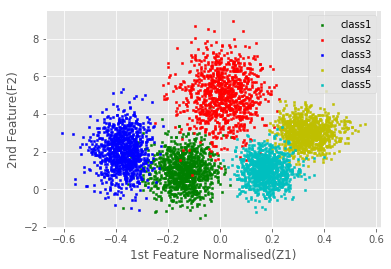

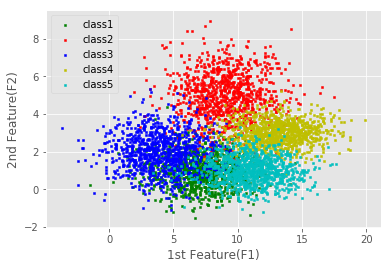

In [12]:
################################### plot plot plot
plt.style.use('ggplot')
fig = plt.figure("Z1 VS F2")
ax1 = fig.add_subplot(111)
ax1.scatter(Z1[0], F2[0], s=5, c='g', marker="s", label='class1')
ax1.scatter(Z1[1], F2[1], s=5, c='r', marker="s", label='class2')
ax1.scatter(Z1[2], F2[2], s=5, c='b', marker="s", label='class3')
ax1.scatter(Z1[3], F2[3], s=5, c='y', marker="s", label='class4')
ax1.scatter(Z1[4], F2[4], s=5, c='c', marker="s", label='class5')
ax1.set_xlabel('1st Feature Normalised(Z1)')
ax1.set_ylabel('2nd Feature(F2)')
ax1.legend()

#plotUsingPlotly(Z1[0], F2[0], Z1[1], F2[1])

fig1 = plt.figure("F1 VS F2")
ax2 = fig1.add_subplot(111)
ax2.scatter(F1[0], F2[0], s=5, c='g', marker="s", label='class1')
ax2.scatter(F1[1], F2[1], s=5, c='r', marker="s", label='class2')
ax2.scatter(F1[2], F2[2], s=5, c='b', marker="s", label='class3')
ax2.scatter(F1[3], F2[3], s=5, c='y', marker="s", label='class4')
ax2.scatter(F1[4], F2[4], s=5, c='c', marker="s", label='class5')
ax2.set_xlabel('1st Feature(F1)')
ax2.set_ylabel('2nd Feature(F2)')
ax2.legend()

plt.show()
###################################


In [13]:
################################### case 2 repeat step 2.1: calculate the mean and variance for Z1:
meanListZ1 = []
varListZ1 = []

#Now using Z1
dataZ1 = pd.Series()
dataTestZ1 = pd.Series()

for i in range(5):
    #train data
    TaskZ1 = Z1.ix[ : 99,i]
    #test data
    TaskTestZ1 = Z1.ix[100 : , i]

    meanZ1, varianceZ1 = TaskZ1.mean(), TaskZ1.var()

    meanListZ1.append(meanZ1)
    varListZ1.append(varianceZ1)

    dataTestZ1 = dataTestZ1.append(TaskTestZ1)

    dataZ1 = dataZ1.append(TaskZ1)

# lets get the prediction accuracy and error rate using log likelyhood approach Z1
maxProbListZ1 = []
for i in range(5):
    TaskTestZ1 = Z1.ix[100:, i]
    for j in range(len(TaskTestZ1)):
        valuesZprobs = []
        for k in range(5):

            probClass = norm.pdf(meanListZ1[k], varListZ1[k], TaskTestZ1.iloc[j])
            valuesZprobs.append(probClass)
        maxProbListZ1.append(valuesZprobs.index(max(valuesZprobs)))

classification_accuracy_Maximum_likelyhood_Z1, error_rate_Maximum_likelyhood_Z1 = getAccuracy(maxProbListZ1, yTestOp)
#print("classification_accuracy_Maximum_likelyhood_z1 " + "error_rate_Maximum_likelyhood_z1", classification_accuracy_Maximum_likelyhood_Z1, error_rate_Maximum_likelyhood_Z1)

# naive bayes using Z1
modelZ1 = gnb.fit(dataZ1.values.reshape(-1, 1), Y)
y_predZ1 = model.predict(dataTestZ1.values.reshape(-1, 1))
classification_accuracy_NB_Z1, error_rate_NB_Z1 = getAccuracy(y_predZ1, yTestOp)
print("Case 2: X = z1 \nclassification_accuracy_Z1 " + "error_rate_Z1", classification_accuracy_NB_Z1, error_rate_NB_Z1)
###################################

Case 2: X = z1 
classification_accuracy_Z1 error_rate_Z1 0.862 0.138


In [14]:
################################### case 3
classification_accuracy_Maximum_likelyhood_F2, error_rate_Maximum_likelyhood_F2 = getAccuracy(y_predF2, yTestOp)
print("Case 3: X = F2 \nclassification_accuracy_F2 " + "error_rate_F2", classification_accuracy_Maximum_likelyhood_F2, error_rate_Maximum_likelyhood_F2)
###################################

Case 3: X = F2 
classification_accuracy_F2 error_rate_F2 0.3442222222222222 0.6557777777777778


In [15]:
################################### case 4
# use naive bayes for getting predictions based on Z1 and F2
dftrainCase4 = pd.DataFrame(data=dict(Z1=dataZ1, F2=dataF2))
dftestCase4 = pd.DataFrame(data=dict(Z1=dataTestZ1, F2=dataTestF2))

modelZ1F2 = gnb.fit(dftrainCase4.values, Y)
y_predZ1F2 = modelZ1F2.predict(dftestCase4)
classification_accuracy_Z1F2, error_rate_Z1F2 = getAccuracy(y_predZ1F2, yTestOp)
print("Case 4: X = [Z1 F2] \nclassification_accuracy_Z1F2 " + "error_rate_Maximum_Z1F2", classification_accuracy_Z1F2, error_rate_Z1F2)
###################################

Case 4: X = [Z1 F2] 
classification_accuracy_Z1F2 error_rate_Maximum_Z1F2 0.9726666666666667 0.027333333333333334
